In [1]:
import sys; sys.path += ['..']
from main_analysis import *
from copy import deepcopy

#from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
benchmark, region = 'shared1000_OTC-only', 'OTC'
benchmark = NSDBenchmark(*benchmark.split('_'))

Now loading the shared1000 image set and the OTC-only voxel set...


In [3]:
model_string = 'RN50_clip' # from OpenAI
model_option = get_model_options()[model_string]
model = eval(model_option['call'])

if model.training:
    model = model.eval()

image_transforms = get_recommended_transforms(model_string)
image_path = benchmark.stimulus_data.image_path
image_loader = DataLoader(StimulusSet(image_path, image_transforms), 
                          shuffle = False, batch_size = 64)

setuptools version: 70.3.0


In [4]:
sample_inputs = next(iter(image_loader))[:3]

In [5]:
model_layer_names = get_empty_feature_maps(model, names_only = True, input_shape = (3,224,224))

In [6]:
feature_maps = get_all_feature_maps(model, image_loader, layers_to_retain = model_layer_names[-1])

In [7]:
voxel_responses = benchmark.response_data

In [8]:
X = feature_maps['AttentionPool2d-1']
y = voxel_responses.to_numpy()

alpha_values = np.logspace(-1,5,7).tolist()
regression = RidgeCVMod(alphas=alpha_values, alpha_per_target=True,
                        scoring='pearson_r', store_cv_values=True)

regression.fit(X, y.transpose())

best_alpha_idx = np.array([alpha_values.index(alpha_) for alpha_ in regression.alpha_])
predictions = np.take_along_axis(regression.cv_values_, 
                                 best_alpha_idx[None,:,None], axis = 2)[:,:,0]

In [9]:
pca_fits = {}; pca_fits['Brain Responses'] = PCA(n_components=3, svd_solver='full').fit_transform(y.transpose())
pca_fits['Model Features'] = PCA(n_components=3, svd_solver='full').fit_transform(X)
pca_fits['Model Features with Encoding'] = PCA(n_components=3, svd_solver='full').fit_transform(predictions)

In [16]:
pca_plot_data = [] # stitched x,y,z for PC3 space:
for index, (key, value) in enumerate(pca_fits.items()):
    pca_data = pd.DataFrame(value)
    pca_data.columns = ['X','Y','Z']
    pca_data.insert(0, 'Activity', key)

    pca_plot_data += [pca_data]

pca_plot_data = pd.concat(pca_plot_data)

# save to source_data if needed:
output_dir = '../results_press'
if os.path.exists(output_dir):
    pca_plot_data.to_csv(f'../results_press/activation_pcspace.csv', index=None)

### PCA Plots

#### PCA Plotting Function

In [11]:
from mpl_toolkits.mplot3d import axes3d, art3d
from parula_cmap import parula_cmap

def pca_plot(pcs, ax, title = None, points_only=True):
    
    x, y, z = pcs[:,0], pcs[:,1], pcs[:,2]
    
    ax.scatter3D(xs = x, ys = y, zs = z, 
                 s = 10.0, c = range(1000), cmap = parula_cmap)
    
    # remove axis labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    try: # removing 3D axis lines using older method:
    
        # remove axis lines
        ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        
        # transparent background
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    except Exception: # use newer method
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.pane.set_edgecolor((1.0, 1.0, 1.0, 0.0))
    
    # remove background entirely
    ax.set_facecolor((1.0, 1.0, 1.0, 0.0))

    def lims(mplotlims):
        scale = 1.021
        offset = (mplotlims[1] - mplotlims[0])*scale
        return mplotlims[1] - offset, mplotlims[0] + offset
    
    xlims, ylims, zlims = lims(ax.get_xlim()), lims(ax.get_ylim()), lims(ax.get_zlim())
    if not points_only:
        i = np.array([xlims[0], ylims[0], zlims[0]])
        f = np.array([xlims[0], ylims[1], zlims[0]])
        p = art3d.Poly3DCollection(np.array([[i, f]]))
        p.set_color('black')
        ax.add_collection3d(p)

        i = np.array([xlims[0], ylims[1], zlims[0]])
        f = np.array([xlims[0], ylims[1], zlims[1]])
        p = art3d.Poly3DCollection(np.array([[i, f]]))
        p.set_color('black')
        ax.add_collection3d(p)

        i = np.array([xlims[0], ylims[1], zlims[0]])
        f = np.array([xlims[1], ylims[1], zlims[0]])
        p = art3d.Poly3DCollection(np.array([[i, f]]))
        p.set_color('black')
        ax.add_collection3d(p)
        
        # add labels at limits of each axis
        ax.text(xlims[0], ylims[0], zlims[0], 'PC1', ha = 'right', va = 'top')
        ax.text(xlims[1], ylims[1], zlims[0], 'PC2', ha = 'left', va = 'top')
        ax.text(xlims[0], ylims[1], zlims[1], 'PC3', ha = 'center', va = 'bottom')
    
    plt.gca().grid(False)
    if title:
        plt.title(title)

#### Apply Plots to Data

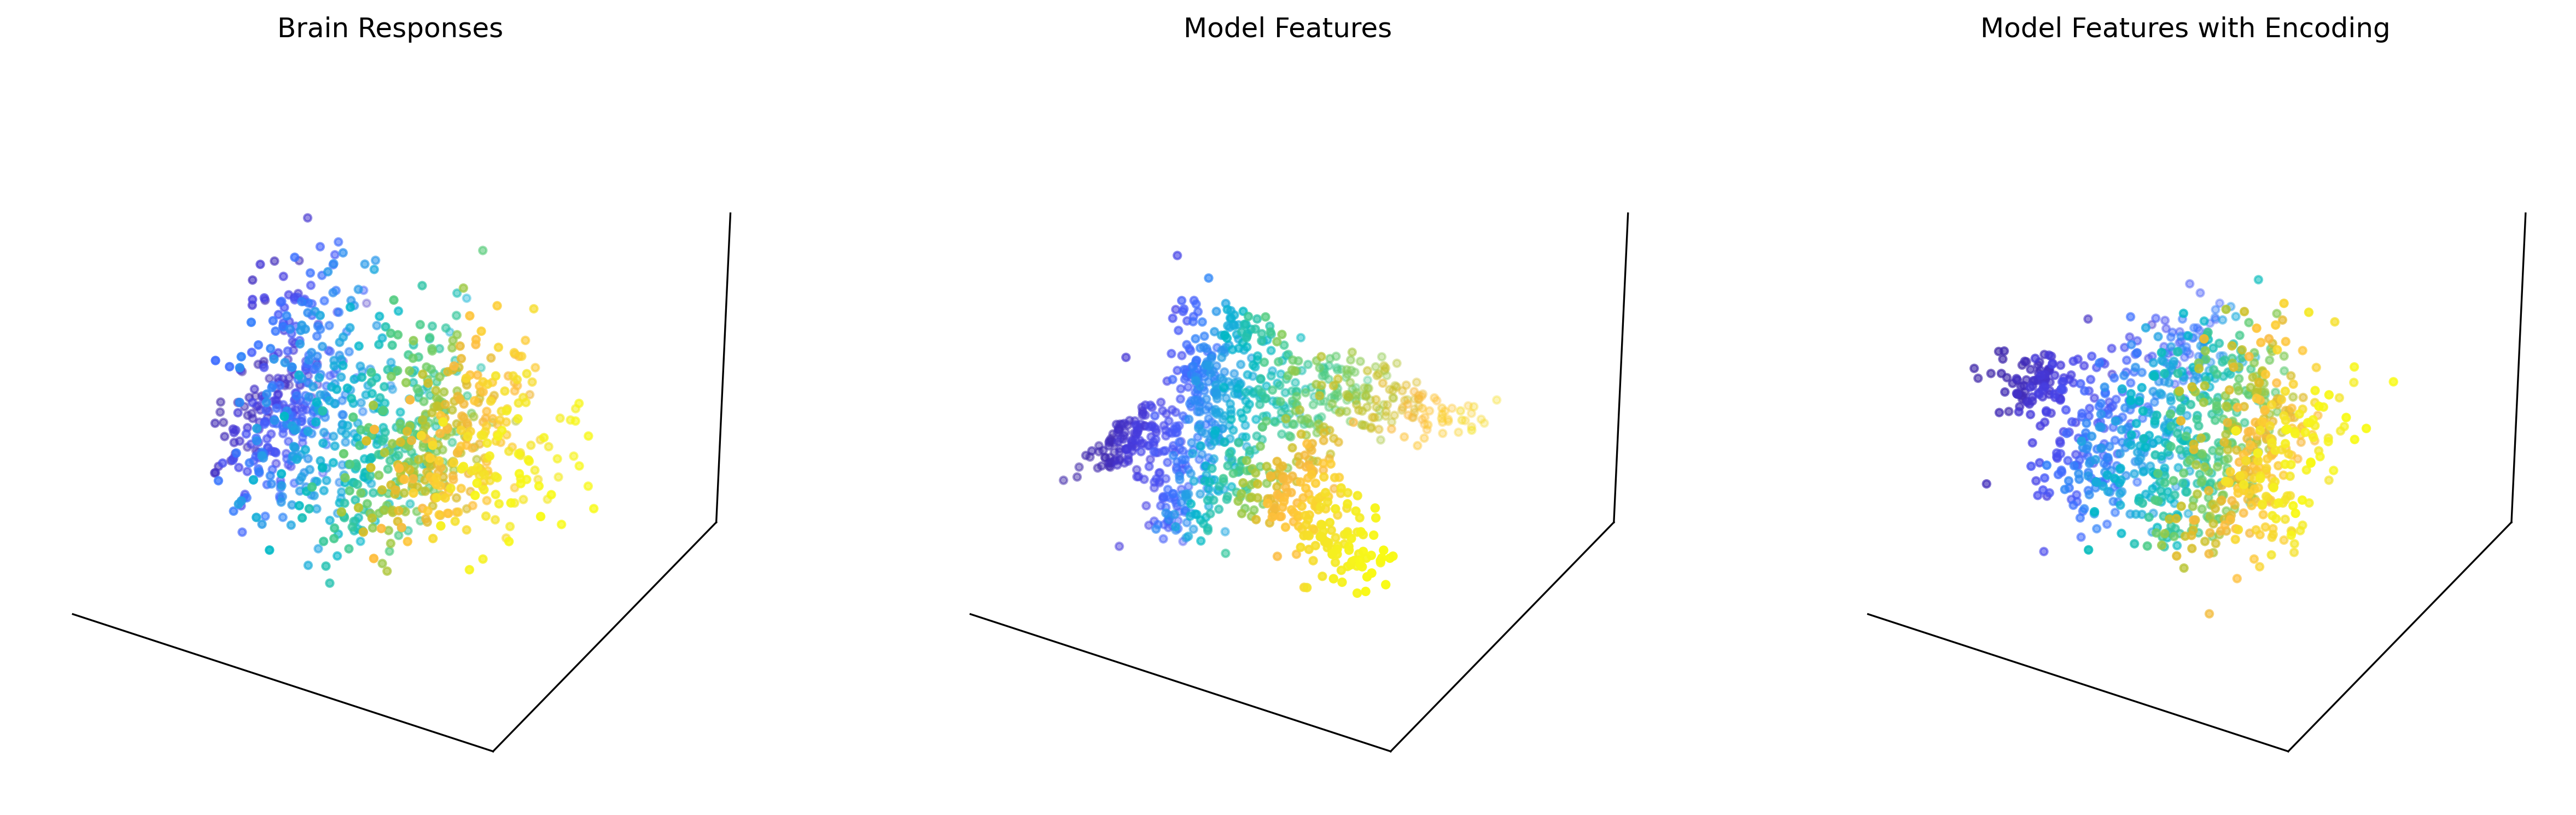

In [12]:
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize = (20,10))

for i, (key, val) in enumerate(pca_fits.items()):
    ax = plt.subplot(1,3,i+1, projection = '3d')
    pcs = pd.DataFrame(pca_fits[key]).sort_values(by = 0).to_numpy()
    
    pca_plot(pcs, ax, title = key)